# 1. Env Setup

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import string
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
from sklearn.model_selection import train_test_split

In [2]:
import kagglehub

# 下载最新版本数据集（注意：下载目录结构可能为：path/images/*.png）
path = kagglehub.dataset_download("parsasam/captcha-dataset")
print("Path to dataset files:", path)

C:\Users\tfgmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\tfgmo\.cache\kagglehub\datasets\parsasam\captcha-dataset\versions\1


# 2. Data Preprocessing

In [ ]:
# 参数设置
img_width = 200
img_height = 64  # 建议图像高度设置为64，这样经过多次pooling后尺寸更合理
batch_size = 256
num_chars = 5   # 验证码字符数固定为5

num_epochs = 100
patience = 10

In [4]:
# 定义字符集（数字 + 大写字母 + 小写字母，共62个字符）
characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
# 在这里我们让字符映射从0开始，最后一个索引预留给 blank
char_to_num = {char: i for i, char in enumerate(characters)}
num_to_char = {i: char for char, i in char_to_num.items()}
# blank index 设为 len(characters)
blank_idx = len(characters)
num_classes = len(characters) + 1  # 加上 blank

def text_to_labels(text):
    """将验证码文本转换为数字列表（不含 blank）"""
    return [char_to_num[c] for c in text]

In [ ]:
class CachedCaptchaDataset(data.Dataset):
    def __init__(self, image_paths, transform=None, num_aug=3):
        """
        在初始化时，将所有图片通过数据增强生成多个样本加载到内存中缓存。
        每张图片将生成5个增强版本。
        
        :param image_paths: 图片文件路径列表
        :param transform: 数据增强和转换（例如 ToTensor），应包含随机变换操作
        """
        self.image_paths = image_paths
        self.transform = transform
        self.cache = []  # 用于存放 (img_tensor, label_tensor, label_len, label_str)
        
        print("Caching {} images (each generating 3 augmented samples)...".format(len(image_paths)))
        for img_path in self.image_paths:
            # 1) 读取并转换为 RGB
            img = Image.open(img_path).convert('RGB')
            # 2) 调整图像尺寸
            img = img.resize((img_width, img_height))
            # 3) 提取标签（假设文件名格式为 "..._{label}.png"）
            basename = os.path.basename(img_path)
            label_str = os.path.splitext(basename)[0].split('_')[-1]
            label = text_to_labels(label_str)
            label_len = len(label)
            # 4) 根据数据增强生成5个增强样本
            for i in range(num_aug):
                if self.transform:
                    aug_img = self.transform(img)
                else:
                    aug_img = transforms.ToTensor()(img)
                self.cache.append((aug_img, torch.tensor(label, dtype=torch.long), label_len, label_str))
        print("Caching complete. Total cached samples:", len(self.cache))

    def __len__(self):
        return len(self.cache)
    
    def __getitem__(self, index):
        return self.cache[index]

def collate_fn(batch):
    imgs, labels, label_lens, label_strs = zip(*batch)
    imgs = torch.stack(imgs, 0)  # (B, 3, H, W)
    targets = torch.cat([lbl for lbl in labels])
    target_lengths = torch.tensor(label_lens, dtype=torch.long)
    # 对于 CTC 模型，通常需要输入序列长度；但这里我们采用固定输出长度模型，不再使用CTC
    # 这里仅返回数据
    return imgs, targets, target_lengths, label_strs

In [6]:
# 数据增强：加入随机旋转、仿射变换、颜色抖动等
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5),
    transforms.ToTensor(),
])

dataset_dir = os.path.join(path, "images")
if not os.path.exists(dataset_dir):
    dataset_dir = path

all_images = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
# 首先随机打乱所有图像路径
np.random.shuffle(all_images)

# 假设 all_images 是已经随机打乱的图像路径列表
train_images, test_val_images = train_test_split(all_images, test_size=0.1, random_state=42)
test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)
# 0.1765 ≈ 0.15 / 0.85，使得训练集约70%，验证集约15%，测试集15%

# 构建训练和验证数据集 (CachedCaptchaDataset)
train_dataset = CachedCaptchaDataset(train_images, transform=data_transform)
val_dataset = CachedCaptchaDataset(val_images, transform=transforms.ToTensor(), num_aug=1)
test_dataset = CachedCaptchaDataset(test_images, transform=transforms.ToTensor(), num_aug=1)

# 创建DataLoader
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                               collate_fn=collate_fn, num_workers=0, pin_memory=True)

val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=collate_fn, num_workers=0, pin_memory=True)

test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=collate_fn, num_workers=0, pin_memory=True)

torch.backends.cudnn.benchmark = True

Caching 101755 images (each generating 5 augmented samples)...
Caching complete. Total cached samples: 305265
Caching 5654 images (each generating 5 augmented samples)...
Caching complete. Total cached samples: 5654
Caching 5653 images (each generating 5 augmented samples)...
Caching complete. Total cached samples: 5653


# 3. Modeling

In [7]:
# 模型部分：编码器+注意力解码器

class AttentionDecoder(nn.Module):
    def __init__(self, num_chars, hidden_dim):
        super(AttentionDecoder, self).__init__()
        # learnable queries for each character position (num_chars, hidden_dim)
        self.queries = nn.Parameter(torch.randn(num_chars, hidden_dim))
    
    def forward(self, encoder_outputs):
        # encoder_outputs: [B, T, hidden_dim]
        B, T, D = encoder_outputs.size()
        # expand queries to batch: [B, num_chars, hidden_dim]
        queries = self.queries.unsqueeze(0).expand(B, -1, -1)  # [B, num_chars, hidden_dim]
        # Compute attention scores: (B, num_chars, T)
        scores = torch.bmm(queries, encoder_outputs.transpose(1, 2))
        attn_weights = torch.softmax(scores, dim=-1)  # [B, num_chars, T]
        # context: weighted sum over time steps
        context = torch.bmm(attn_weights, encoder_outputs)  # [B, num_chars, hidden_dim]
        return context

class AttentionOCR(nn.Module):
    def __init__(self, num_classes, num_chars=5):
        super(AttentionOCR, self).__init__()
        # CNN部分：提取特征，保留时序信息
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 输出: (B,32,32,100)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 输出: (B,64,16,50)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,1), (2,1))  # 输出: (B,128,8,50)
        )
        # 将 conv3 输出形状 [B, 128, 8, 50] 变为时序特征
        # 时序长度 T=50, 每个时间步特征维度 = 128*8 = 1024
        self.fc = nn.Linear(128 * 8, 64)  # 降维至64
        # 双向 GRU：输入64，隐藏层128，双向输出维度256
        self.gru = nn.GRU(64, 128, num_layers=1, bidirectional=True, batch_first=True, dropout=0.25)
        # 注意力解码器：生成固定 num_chars 个输出，每个维度为256
        self.attention_decoder = AttentionDecoder(num_chars, hidden_dim=256)
        # 分类器：对每个解码输出映射到字符类别
        self.classifier = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)  # shape: [B, 128, 8, 50]
        B, C, H, W = x.size()
        # 将特征图转换为时序形式：每个时间步对应宽度方向的一列
        x = x.permute(0, 3, 1, 2).contiguous().view(B, W, C * H)  # [B, 50, 128*8]
        # 降维到64
        x = self.fc(x)  # [B, 50, 64]
        # GRU编码：输出 [B, 50, 256]
        encoder_outputs, _ = self.gru(x)
        # 注意力解码器：输出 [B, num_chars, 256]
        decoder_outputs = self.attention_decoder(encoder_outputs)
        # 分类器：对每个字符位置输出 logits [B, num_chars, num_classes]
        logits = self.classifier(decoder_outputs)
        logits = self.log_softmax(logits)
        return logits

In [8]:
# Beam Search 解码 (固定输出长度)
def beam_search_decode(logits, beam_width=3):
    """
    logits: [B, num_chars, num_classes] (log probabilities)
    对每个样本，使用 beam search 返回最优的字符序列（作为 list of strings）
    这里简单实现：由于每个位置独立，beam search 实际上就是取每个位置 top-k 后组合
    """
    B, num_chars, num_classes = logits.size()
    all_sequences = []
    # 对于每个样本
    for b in range(B):
        sample_logits = logits[b]  # [num_chars, num_classes]
        # 对每个字符位置取 top beam_width 索引及得分
        topk_vals, topk_idx = sample_logits.topk(beam_width, dim=1)  # 每个位置 (beam_width)
        # 生成所有可能的组合（beam_width^num_chars个候选）
        # 这里如果 beam_width^num_chars 太大，可以采用剪枝；但 num_chars=5且 beam_width=3 共243个组合，可以直接遍历
        candidates = [[]]
        candidate_scores = [0.0]
        for pos in range(num_chars):
            new_candidates = []
            new_scores = []
            for cand, score in zip(candidates, candidate_scores):
                for i in range(beam_width):
                    new_candidates.append(cand + [topk_idx[pos, i].item()])
                    new_scores.append(score + topk_vals[pos, i].item())
            candidates = new_candidates
            candidate_scores = new_scores
        # 选取得分最高的候选序列
        best_idx = np.argmax(candidate_scores)
        best_sequence = candidates[best_idx]
        # 转换为字符串
        pred_text = "".join([characters[i] for i in best_sequence])
        all_sequences.append(pred_text)
    return all_sequences

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionOCR(num_classes, num_chars=num_chars).to(device)
print(model)

# 使用预训练模型：这里假设预训练权重文件路径（如存在）
pretrained_model_path = 'crnn.pth'
if os.path.exists(pretrained_model_path):
    pretrained_dict = torch.load(pretrained_model_path, map_location='cpu')
    model_dict = model.state_dict()
    # 过滤掉不匹配的层
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    model.to(device)
    print("Loaded pretrained weights successfully.")
else:
    print("Pretrained model not found, training from scratch.")

# 如果预训练模型的分类器输出维度不匹配，可重新定义
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes).to(device)
print("Adjusted classifier layer for our character set.")

# 定义损失和优化器（由于固定输出使用交叉熵损失，对每个字符位置）
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

AttentionOCR(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1024, out_features=64, bias=True)
  (gru): GRU(64, 128, batch_first=True, dropout=0.25, bidirectional=True)
  (attention_decoder): AttentionDecoder()
  (classifier): Linear(in_features=256, out_features=63, bias=True)
  (log_softmax): LogSoftmax(dim=2)
)


C:\Users\tfgmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Loaded pretrained weights successfully.
Adjusted classifier layer for our character set.


## Model Training

In [10]:
best_val_loss = np.inf
epochs_no_improve = 0
best_model_wts = deepcopy(model.state_dict())
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets, target_lengths, label_strs in train_loader:
        # imgs: [B, 3, H, W], targets: 拼接的标签 (不再使用，因为我们采用固定输出)
        # 我们在固定输出模型中，每个样本有5个字符标签，原始 targets 为一维，需要先分割
        # 这里我们假设每个 sample 标签长度固定为 num_chars
        B = imgs.size(0)
        # 构造目标：形状 [B, num_chars]
        all_targets = []
        for i in range(B):
            # label_strs[i] 为真实标签字符串，若长度不足则填充空字符（或错误处理），这里假设总是5个字符
            label = label_strs[i]
            if len(label) < num_chars:
                label = label + (" " * (num_chars - len(label)))
            elif len(label) > num_chars:
                label = label[:num_chars]
            # 将每个字符转换为数字索引
            label_idx = [characters.index(c) if c in characters else 0 for c in label]
            all_targets.append(torch.tensor(label_idx, dtype=torch.long))
        targets_fixed = torch.stack(all_targets, dim=0)  # [B, num_chars]
        
        imgs = imgs.to(device)
        targets_fixed = targets_fixed.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)  # [B, num_chars, num_classes]
        # 计算每个字符位置的交叉熵损失，reshape为 (B*num_chars, num_classes)
        loss = criterion(outputs.view(-1, num_classes), targets_fixed.view(-1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * B
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # 验证
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets, target_lengths, label_strs in val_loader:
            B = imgs.size(0)
            all_targets = []
            for i in range(B):
                label = label_strs[i]
                if len(label) < num_chars:
                    label = label + (" " * (num_chars - len(label)))
                elif len(label) > num_chars:
                    label = label[:num_chars]
                label_idx = [characters.index(c) if c in characters else 0 for c in label]
                all_targets.append(torch.tensor(label_idx, dtype=torch.long))
            targets_fixed = torch.stack(all_targets, dim=0)  # [B, num_chars]
            
            imgs = imgs.to(device)
            targets_fixed = targets_fixed.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs.view(-1, num_classes), targets_fixed.view(-1))
            val_loss += loss.item() * B
    val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("=> Validation loss decreased, saving model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("=> Early stopping")
            break

model.load_state_dict(best_model_wts)

Epoch 1/100 Train Loss: 3.9307 Val Loss: 3.2540
=> Validation loss decreased, saving model.
Epoch 2/100 Train Loss: 2.6873 Val Loss: 2.0080
=> Validation loss decreased, saving model.
Epoch 3/100 Train Loss: 1.8966 Val Loss: 1.4668
=> Validation loss decreased, saving model.
Epoch 4/100 Train Loss: 1.5046 Val Loss: 1.1477
=> Validation loss decreased, saving model.
Epoch 5/100 Train Loss: 1.2609 Val Loss: 0.9671
=> Validation loss decreased, saving model.
Epoch 6/100 Train Loss: 1.0937 Val Loss: 0.8367
=> Validation loss decreased, saving model.
Epoch 7/100 Train Loss: 0.9713 Val Loss: 0.7628
=> Validation loss decreased, saving model.
Epoch 8/100 Train Loss: 0.8791 Val Loss: 0.6767
=> Validation loss decreased, saving model.
Epoch 9/100 Train Loss: 0.8069 Val Loss: 0.6267
=> Validation loss decreased, saving model.
Epoch 10/100 Train Loss: 0.7456 Val Loss: 0.5903
=> Validation loss decreased, saving model.
Epoch 11/100 Train Loss: 0.6959 Val Loss: 0.5487
=> Validation loss decreased, 

<All keys matched successfully>

## 4. Model Validation

Strict Validation Accuracy: 69.89%
Case-Insensitive Validation Accuracy: 86.45%


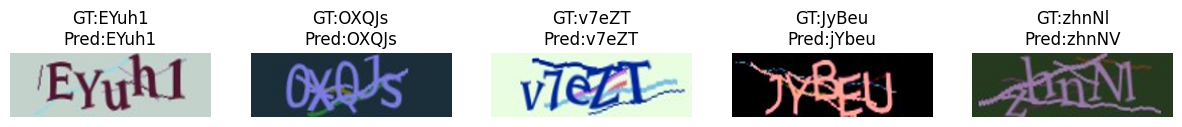

In [11]:
# ------------------------------
# 8. 定义预测函数（贪婪解码）
# ------------------------------
def greedy_decode(outputs):
    """
    outputs: tensor of shape [batch_size, num_chars, num_classes]
    """
    preds = outputs.argmax(dim=2).cpu().numpy()  # (B, num_chars)
    decoded_preds = []
    for pred in preds:
        decoded = ''.join([num_to_char[idx] for idx in pred])
        decoded_preds.append(decoded)
    return decoded_preds

# ------------------------------
# 9. 在验证集上评估模型性能
# ------------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, targets, target_lengths, label_strs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)  # [B, num_chars, num_classes]
        preds = outputs.argmax(dim=2).cpu().numpy()  # greedy decode即可
        preds_str = [''.join([num_to_char[idx] for idx in pred]) for pred in preds]
        all_preds.extend(preds_str)
        all_labels.extend(label_strs)

# 严格匹配准确率（区分大小写）
correct = sum(1 for gt, pred in zip(all_labels, all_preds) if gt.strip() == pred.strip())
accuracy = correct / len(all_labels)

# 忽略大小写的准确率
correct_insensitive = sum(
    1 for gt, pred in zip(all_labels, all_preds) if gt.strip().lower() == pred.strip().lower()
)
accuracy_insensitive = correct_insensitive / len(all_labels)

print(f"Strict Validation Accuracy: {accuracy:.2%}")
print(f"Case-Insensitive Validation Accuracy: {accuracy_insensitive:.2%}")
# ------------------------------
# 10. 可视化部分验证样本的预测结果
# ------------------------------
# 从最后一个 batch 中随机选择几个样本
# 可视化示例代码
imgs_vis = imgs.cpu().permute(0, 2, 3, 1).numpy()
num_samples = min(5, imgs_vis.shape[0])
plt.figure(figsize=(15,3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(imgs_vis[i])
    plt.title(f'GT:{label_strs[i]}\nPred:{preds_str[i]}')
    plt.axis('off')
plt.show()

In [12]:
torch.save(model.state_dict(), 'best_model.pth')